In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch


In [8]:
data = pd.read_csv('Reviews.csv')
data.shape

(568454, 10)

In [9]:
data = data.drop_duplicates(subset = {"UserId","ProfileName","Time","Text"})
data = data[data['HelpfulnessNumerator'] <= data['HelpfulnessDenominator']]
data.shape

(393931, 10)

In [11]:
data = data.dropna()
data.shape

(393917, 10)

In [12]:
import warnings
warnings.filterwarnings("ignore")                     #Ignoring unnecessory warnings

import numpy as np                                  #for large and multi-dimensional arrays
import pandas as pd

import nltk                                         #Natural language processing tool-kit

from nltk.corpus import stopwords                   #Stopwords corpus
from nltk.stem import PorterStemmer                 # Stemmer

from sklearn.feature_extraction.text import CountVectorizer          #For Bag of words
from sklearn.feature_extraction.text import TfidfVectorizer          #For TF-IDF
from gensim.models import Word2Vec 

In [13]:
#basic cleaning
import time

data = data.drop_duplicates(subset = {"UserId","ProfileName","Time","Text"})
data = data[data['HelpfulnessNumerator'] <= data['HelpfulnessDenominator']]

nltk.download('stopwords')

stop = set(stopwords.words('english'))

#removing spaces and stopwords
import re
# function to clean data
def clean_data(X):
    temp =[]
    snow = nltk.stem.SnowballStemmer('english')
    start = time.time()
    for i, sentence in enumerate(X):
        if i%10000 == 0:
            print(i, 'Time taken:', time.time()-start)
            start = time.time()
        sentence = sentence.lower()                 # Converting to lowercase
        cleanr = re.compile('<.*?>')
        sentence = re.sub(cleanr, ' ', sentence)        #Removing HTML tags
        sentence = re.sub(r'[?|!|\'|"|#]',r'',sentence)
        sentence = re.sub(r'[.|,|)|(|\|/]',r' ',sentence)        #Removing Punctuations

        words = [snow.stem(word) for word in sentence.split()]   # Stemming
        temp.append(words)

    X = temp    

    sent = []
    for row in X:
        sequ = ''
        for word in row:
            sequ = sequ + ' ' + word
        sent.append(sequ)

    return sent

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/klejdisevdari/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [14]:
X, y = data['Text'], data['Score']

<AxesSubplot:>

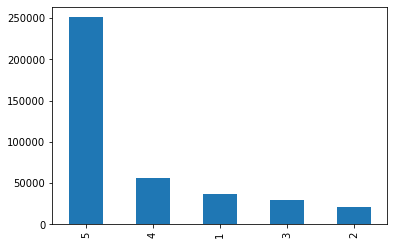

In [15]:
y.value_counts().plot(kind='bar')

<AxesSubplot:>

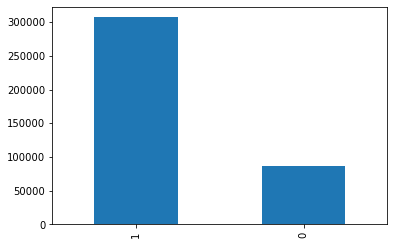

In [16]:
y[y<4] = 0 # negative class
y[y>=4] = 1 # positive class
y.value_counts().plot(kind='bar')

In [17]:
y = np.array(y) # to convert to numpy array

In [18]:
cleaned_data = clean_data(X)

0 Time taken: 1.6927719116210938e-05
10000 Time taken: 4.26750111579895
20000 Time taken: 4.606721878051758
30000 Time taken: 4.318329811096191
40000 Time taken: 4.398187637329102
50000 Time taken: 4.386837005615234
60000 Time taken: 4.6317079067230225
70000 Time taken: 4.903625011444092
80000 Time taken: 4.382453918457031
90000 Time taken: 4.531135082244873
100000 Time taken: 4.221998929977417
110000 Time taken: 4.624211072921753
120000 Time taken: 4.828066110610962
130000 Time taken: 4.346555233001709
140000 Time taken: 4.350635051727295
150000 Time taken: 4.977027893066406
160000 Time taken: 4.578828811645508
170000 Time taken: 4.368210077285767
180000 Time taken: 4.323323965072632
190000 Time taken: 4.393045902252197
200000 Time taken: 4.8498170375823975
210000 Time taken: 4.4135520458221436
220000 Time taken: 4.37319016456604
230000 Time taken: 4.6422529220581055
240000 Time taken: 4.18298077583313
250000 Time taken: 4.431384801864624
260000 Time taken: 4.50162410736084
270000 Tim

In [19]:
len(cleaned_data), len(y) # checking if the length of cleaned data and y is same

(393917, 393917)

# TF-IDF

In [64]:
final_tf = cleaned_data
tf_idf = TfidfVectorizer(max_features=5000)
tf_data = tf_idf.fit_transform(final_tf)
tf_data.shape

(393917, 5000)

In [21]:
temp = tf_data.toarray() # turning sparse matrix into dense matrix

In [22]:
type(temp), temp.shape

(numpy.ndarray, (393917, 5000))

In [23]:
torch.Tensor(temp[0:2]).shape # 2 rows and 10000 columns

torch.Size([2, 5000])

In [33]:
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split

train_data, test_data, train_labels, test_labels = train_test_split(temp, y, test_size=0.2, random_state=42)

# Convert NumPy arrays to PyTorch tensors
train_data, train_labels = torch.from_numpy(train_data).float(), torch.from_numpy(train_labels).float()
test_data, test_labels = torch.from_numpy(test_data).float(), torch.from_numpy(test_labels).float()

# Create TensorDatasets for train and test sets
train_dataset = TensorDataset(train_data, train_labels)
test_dataset = TensorDataset(test_data, test_labels)

# Create DataLoaders for train and test sets
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

In [58]:
import torch.nn as nn
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(5000, 1000),
            nn.ReLU(),
            nn.Linear(1000, 100),
            nn.ReLU(),
            nn.Linear(100, 1),
        )

    def forward(self, x):
        logits = self.linear_relu_stack(x)
        return nn.functional.sigmoid(logits)

net = NeuralNetwork()

In [59]:
import torch.optim as optim

criterion = nn.BCELoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [60]:
for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        labels = torch.unsqueeze(labels, 1)
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        try:
            loss = criterion(outputs, labels)
        except:
            print(inputs, outputs)
        
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 0.547
[1,  4000] loss: 0.524
[1,  6000] loss: 0.526
[1,  8000] loss: 0.528
[1, 10000] loss: 0.520
[1, 12000] loss: 0.525
[1, 14000] loss: 0.524
[1, 16000] loss: 0.509
[1, 18000] loss: 0.491
[2,  2000] loss: 0.379
[2,  4000] loss: 0.342
[2,  6000] loss: 0.314
[2,  8000] loss: 0.300
[2, 10000] loss: 0.287
[2, 12000] loss: 0.285
[2, 14000] loss: 0.279
[2, 16000] loss: 0.278
[2, 18000] loss: 0.272
Finished Training


In [61]:
cleaned_data[0]

' i have bought sever of the vital can dog food product and have found them all to be of good qualiti the product look more like a stew than a process meat and it smell better my labrador is finicki and she appreci this product better than most'

In [78]:
sentence = ["I do like this product"]
clean_sentence = clean_data(sentence)
print(clean_sentence)
sparse = tf_idf.transform(clean_sentence)
tensor_sentence = torch.Tensor(sparse.toarray())
prob = net(tensor_sentence)
print(f'Probability of a positive review is {prob.item()}')

0 Time taken: 9.5367431640625e-07
[' i do like this product']
Probability of a positive review is 0.6198616623878479


# Glove